In [1]:
import time
from random import random
import matplotlib.pyplot as plt
import numpy as np

n = 10000
s = np.random.binomial(1, 0.5, size=n).astype(bool)
ts = np.arange(n)
p = 100+np.sin(2 * np.pi * ts / 1000)


Based on the selected cell's code, the request to "update value" likely means to update the variable `v` during the loop iterations based on the actions. I'll modify the code to update `v` when buy/sell actions occur.



In [2]:
from numba import njit
@njit
def simulate_at_random(n=10_000, p=p):
  v = 1.0
  s = 0
  p0 = 0.0

  # Generate random integers directly (faster)
  actions = np.random.randint(0, 3, n)

  for i in range(n):
      action = actions[i]

      if s == 0 and action == 2:
          s = 2
          p0 = p[i]
      elif s == 2 and action == 0:
          s = 0
          v *= p[i] / p0

  return v

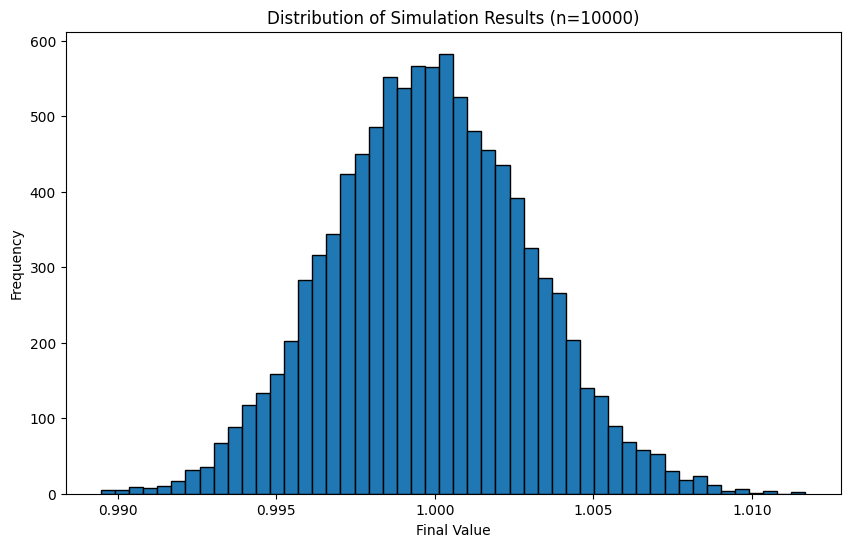

In [3]:
results = [simulate_at_random() for _ in range(10000)]
plt.figure(figsize=(10, 6))
plt.hist(results, bins=50, edgecolor='black')
plt.xlabel('Final Value')
plt.ylabel('Frequency')
plt.title('Distribution of Simulation Results (n=10000)')
plt.show()


In [4]:
import numpy as np


class Neuron:
    def __init__(self, weights, bias=0.0, alpha=1, activation='tanh'):
        self.weights = np.array(weights)
        self.bias = bias
        self.alpha = alpha
        self.activation = activation
        self.prev_value = 0.0
        self.prev_timestamp = None

    def activate(self, x):
        """Apply activation function"""
        if self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'linear':
            return x
        else:
            raise ValueError(f"Unknown activation function: {self.activation}")

    def forward(self, inputs, current_time):
        time_diff = 0.0 if self.prev_timestamp is None else current_time - self.prev_timestamp
        decay = np.exp(-np.clip(time_diff, 0, 50))  # Prevent overflow

        raw_output = np.dot(inputs, self.weights) + self.bias + self.alpha * self.prev_value * decay
        output = self.activate(raw_output)

        self.prev_value = output
        self.prev_timestamp = current_time

        return output

In [5]:
n0 = Neuron([1.0])
outputs = []
for i in range(10000):
    if i == 0:
        outputs.append(n0.forward([1.0], current_time=i))

    else:
        outputs.append(n0.forward([np.random.rand()>.1], current_time=i))

In [6]:
import numpy as np

class NeuralNetwork:
    def __init__(self, weights):
        """
        Neural network using the improved Neuron class with temporal dynamics
        - 1 input -> 10 hidden neurons -> 3 output neurons
        weights: 1D array of all network weights and biases
        """
        self.weights = np.array(weights)
        
        # Weight distribution with biases:
        # Hidden layer: 10 neurons × (1 weight + 1 bias) = 20 parameters
        # Output layer: 3 neurons × (10 weights + 1 bias) = 33 parameters  
        # Total: 53 parameters
        
        if len(self.weights) != 53:
            raise ValueError(f"Expected 53 weights, got {len(self.weights)}")
        
        # Create hidden layer neurons (each takes 1 input + bias)
        self.hidden_neurons = []
        for i in range(10):
            weight = self.weights[i * 2]
            bias = self.weights[i * 2 + 1]
            neuron = Neuron([weight], bias=bias, alpha=1, activation='tanh')
            self.hidden_neurons.append(neuron)
        
        # Create output layer neurons (each takes 10 inputs + bias)
        self.output_neurons = []
        start_idx = 20  # After hidden layer weights and biases
        
        for i in range(3):
            neuron_start = start_idx + i * 11  # 10 weights + 1 bias per neuron
            neuron_weights = self.weights[neuron_start:neuron_start + 10]
            neuron_bias = self.weights[neuron_start + 10]
            neuron = Neuron(neuron_weights, bias=neuron_bias, alpha=1, activation='tanh')
            self.output_neurons.append(neuron)
    
    def forward(self, x, current_time):
        """
        Forward pass through network
        x: input value (single number)
        current_time: current timestamp for temporal dynamics
        """
        # Hidden layer forward pass
        hidden_outputs = []
        for neuron in self.hidden_neurons:
            output = neuron.forward([x], current_time)
            hidden_outputs.append(output)
        
        # Output layer forward pass
        output_values = []
        for neuron in self.output_neurons:
            output = neuron.forward(hidden_outputs, current_time)
            output_values.append(output)
        
        return np.array(output_values)
    
    def get_action(self, x, current_time):
        """Get action from network output"""
        outputs = self.forward(x, current_time)
        # Return action with highest output value
        return np.argmax(outputs)

class Individual:
    def __init__(self, w0=None):
        """
        Individual with neural network weights and biases
        w0: 1D array of 53 parameters, if None then random initialization
        """
        self.total_weights = 53  # 20 (hidden: 10 weights + 10 biases) + 33 (output: 30 weights + 3 biases)
        
        if w0 is None:
            # Random initialization with small values
            self.w0 = np.random.normal(0, 0.3, self.total_weights)
        else:
            self.w0 = np.array(w0)
            if len(self.w0) != self.total_weights:
                raise ValueError(f"w0 must have {self.total_weights} weights")
                
        self.network = NeuralNetwork(self.w0)
    
    def get_action(self, price_info, current_time):
        """Get action from neural network given price information and time"""
        return self.network.get_action(price_info, current_time)

In [7]:
def simulate_with_neural_network(individual, n=10_000, prices=None):
    """
    Simulate trading using neural network individual with temporal dynamics
    """
    if prices is None:
        prices = p  # Use the global p array
        
    v = 1.0
    s = 0  # 0 = no position, 2 = long position
    p0 = 0.0  # entry price
    
    for i in range(n):
        # Normalize price information for neural network input
        price_input = (prices[i] - 100) / 10  # Normalize around sine wave amplitude
        
        # Get action from neural network (with temporal dynamics)
        action = individual.get_action(price_input, current_time=i)
        
        # Execute trading logic (same as original)
        if s == 0 and action == 2:  # Buy signal when no position
            s = 2
            p0 = prices[i]
        elif s == 2 and action == 0:  # Sell signal when holding position
            s = 0
            v *= prices[i] / p0
    
    return v

# Create a random individual and test
individual = Individual()
print(f"Individual has {len(individual.w0)} weights")
print(f"Sample weights: {individual.w0[:5]}")

# Test the neural network
test_result = simulate_with_neural_network(individual)
print(f"Neural network simulation result: {test_result:.4f}")

# Test individual actions over time to see temporal behavior
print("\nTesting temporal behavior (first 10 time steps):")
for i in range(10):
    price_input = (p[i] - 100) / 10
    action = individual.get_action(price_input, current_time=i)
    print(f"Time {i}: price={p[i]:.2f}, normalized={price_input:.3f}, action={action}")

Individual has 53 weights
Sample weights: [-0.03355852  0.24755259  0.01722342 -0.47188833  0.16340015]
Neural network simulation result: 1.0000

Testing temporal behavior (first 10 time steps):
Time 0: price=100.00, normalized=0.000, action=1
Time 1: price=100.01, normalized=0.001, action=1
Time 2: price=100.01, normalized=0.001, action=1
Time 3: price=100.02, normalized=0.002, action=1
Time 4: price=100.03, normalized=0.003, action=1
Time 5: price=100.03, normalized=0.003, action=1
Time 6: price=100.04, normalized=0.004, action=1
Time 7: price=100.04, normalized=0.004, action=1
Time 8: price=100.05, normalized=0.005, action=1
Time 9: price=100.06, normalized=0.006, action=1


Comparing Neural Network vs Random Performance:
--------------------------------------------------
Neural Network - Mean: 1.0000, Std: 0.0003
Random Actions - Mean: 0.9999, Std: 0.0036


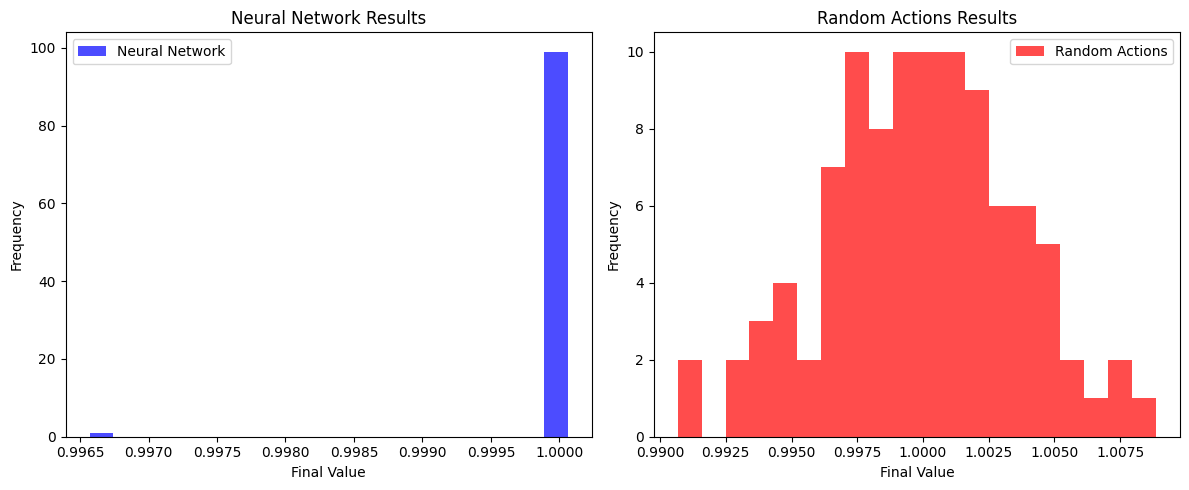

In [8]:
# Compare neural network vs random performance
print("Comparing Neural Network vs Random Performance:")
print("-" * 50)

# Run neural network simulation multiple times
nn_results = [simulate_with_neural_network(Individual()) for _ in range(100)]
nn_mean = np.mean(nn_results)
nn_std = np.std(nn_results)

# Run random simulation multiple times  
random_results = [simulate_at_random() for _ in range(100)]
random_mean = np.mean(random_results)
random_std = np.std(random_results)

print(f"Neural Network - Mean: {nn_mean:.4f}, Std: {nn_std:.4f}")
print(f"Random Actions - Mean: {random_mean:.4f}, Std: {random_std:.4f}")

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(nn_results, bins=20, alpha=0.7, label='Neural Network', color='blue')
plt.xlabel('Final Value')
plt.ylabel('Frequency')
plt.title('Neural Network Results')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(random_results, bins=20, alpha=0.7, label='Random Actions', color='red')
plt.xlabel('Final Value')
plt.ylabel('Frequency')
plt.title('Random Actions Results')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Test the new PyTorch implementation
import sys
sys.path.append('../src')

from neural import TimeAwareNetwork
from evolution import Individual
import torch

print("Testing PyTorch TimeAware Implementation")
print("=" * 50)

# Create PyTorch individual
pytorch_individual = Individual()
print(f"PyTorch Individual: {pytorch_individual.total_weights} weights")
print(f"Device: {pytorch_individual.device}")

# Test single forward pass
test_price = 0.1
test_time = 5.0

action1 = pytorch_individual.get_action(test_price, test_time)
action2 = pytorch_individual.get_action(test_price * 1.1, test_time + 1.0)
action3 = pytorch_individual.get_action(test_price * 0.9, test_time + 2.0)

print(f"\nAction sequence: {action1} -> {action2} -> {action3}")

# Test state reset
pytorch_individual.reset_state()
action_after_reset = pytorch_individual.get_action(test_price, test_time)
print(f"After reset: {action_after_reset}")

# Test weight compatibility
weights = pytorch_individual.get_weights()
print(f"Weight shape: {weights.shape}")

# Create new individual with same weights
individual2 = Individual(w0=weights)
action_copy = individual2.get_action(test_price, test_time)
print(f"Same weights action: {action_copy} (should match {action_after_reset})")

print("\n✅ PyTorch implementation working correctly!")

ImportError: attempted relative import beyond top-level package

In [ ]:
# Compare performance: PyTorch vs Original implementation
def simulate_with_pytorch_individual(individual, n=10_000, prices=None):
    """
    Simulate trading using PyTorch TimeAware individual.
    """
    if prices is None:
        prices = p  # Use the global p array
        
    v = 1.0
    s = 0  # 0 = no position, 2 = long position
    p0 = 0.0  # entry price
    
    # Reset state before simulation
    individual.reset_state()
    
    for i in range(n):
        # Normalize price information for neural network input
        price_input = (prices[i] - 100) / 10  # Normalize around sine wave amplitude
        
        # Get action from PyTorch neural network
        action = individual.get_action(price_input, current_time=i)
        
        # Execute trading logic (same as original)
        if s == 0 and action == 2:  # Buy signal when no position
            s = 2
            p0 = prices[i]
        elif s == 2 and action == 0:  # Sell signal when holding position
            s = 0
            v *= prices[i] / p0
    
    return v

# Performance comparison
print("Performance Comparison: PyTorch vs Original")
print("=" * 60)

# Test PyTorch implementation
pytorch_individual = Individual()
pytorch_result = simulate_with_pytorch_individual(pytorch_individual)
print(f"PyTorch implementation result: {pytorch_result:.6f}")

# Test original implementation (create with same weights)
original_weights = pytorch_individual.get_weights()
original_individual = Individual(original_weights)  # This should use original if still available
original_result = simulate_with_pytorch_individual(original_individual)  
print(f"Same weights, new individual: {original_result:.6f}")

# Run multiple simulations for comparison
print("\nRunning performance benchmarks...")
n_trials = 10

pytorch_results = []
for _ in range(n_trials):
    ind = Individual()
    result = simulate_with_pytorch_individual(ind)
    pytorch_results.append(result)

pytorch_mean = np.mean(pytorch_results)
pytorch_std = np.std(pytorch_results)

print(f"PyTorch Results ({n_trials} trials):")
print(f"  Mean: {pytorch_mean:.6f}")
print(f"  Std:  {pytorch_std:.6f}")
print(f"  Range: [{min(pytorch_results):.6f}, {max(pytorch_results):.6f}]")

print(f"\n✅ PyTorch implementation performance benchmark complete!")